# Using a `Jupyter` notebook and `Zotero` to generate the Journal Club post
#### Some notes
1. This requires you to use Zotero to import the papers **AND** also requires you to **SYNC** them to the Zotero cloud.
1. Syncing it to the cloud offers many advantages should you want to use Zotero to manage your own references.
1. There is however a **major** downside, i.e. Zotero's free tier gives 200MB space in the cloud, so you probably want to preclude syncing attachments 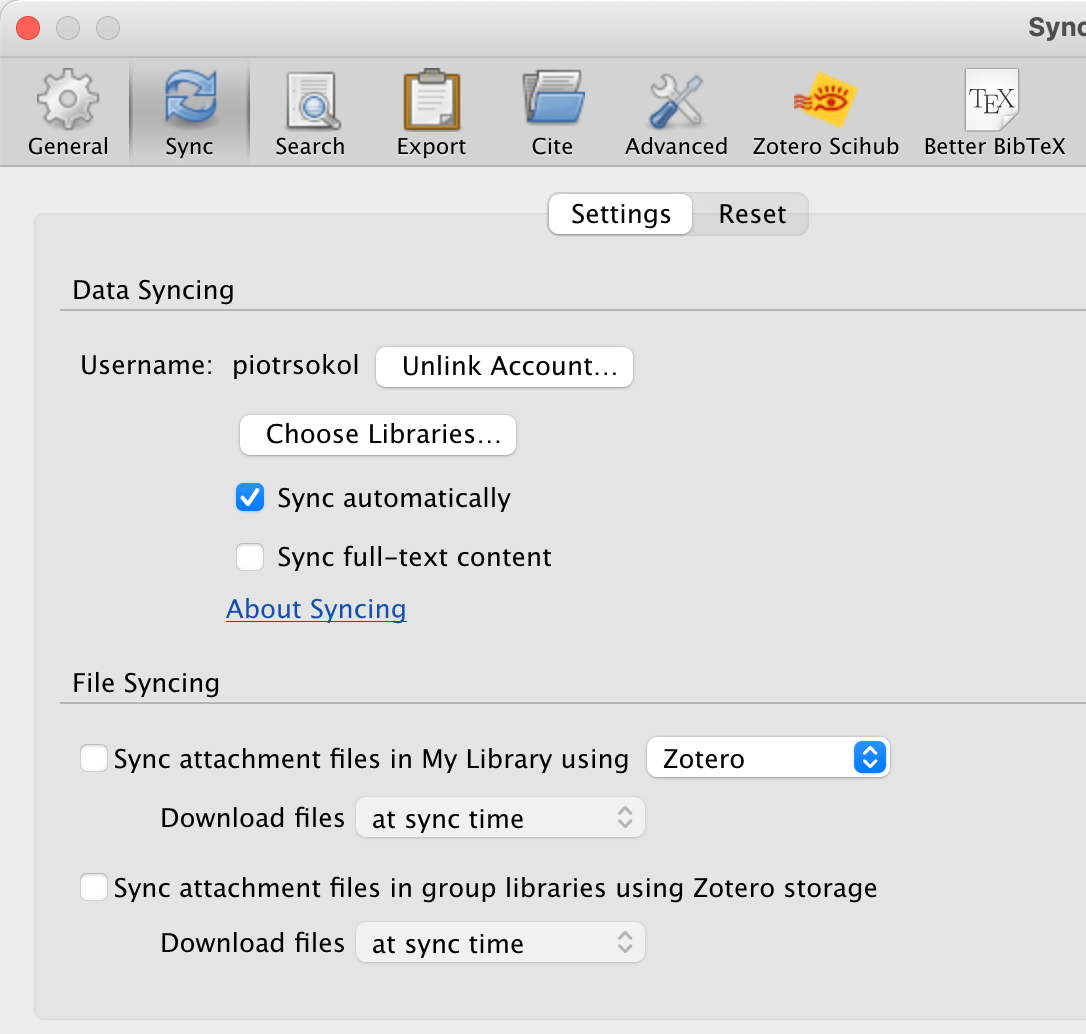

### First, make sure you've installed `pyztoero`
For convenience uncomment below and run (installs in current environment)

In [ ]:
# %pip install --user pyzotero

In [6]:
from pyzotero import zotero
import datetime
import re
import os
from unidecode import unidecode
import urllib.parse
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
import base64
import ipywidgets as widgets
from IPython.display import display, HTML
import threading

## Define some common variables
### `Zotero`:

In [4]:
library_id = 8888888  # 8 digit long number, that can be recovered from the Zotero website
api_key = "your-api-key" # 
library_type = "user"  # keep this constant

#### you can find the `library_id` and `api_key` at https://www.zotero.org/settings/keys (assuming you've made an account)

#### path to where `catniplab.github.io` directory lives

In [ ]:
pth = "/Users/piotrsokol/Documents/"
pth+= 'catniplab.github.io/journalclub/_posts"

### Variables specific to each meeting:
1. `how_many_weeks_into_the_future` (this week =0 , next week = 1)
**Important: add 1 week if it's before Monday of the desired week**

2. `presenter`

2. `title` must match the title of the paper in `Zotero`
2. `pdfname` name of the pdf that will copied into the `catniplab.github.io` repo (under `journalclub/JCpapers`)

In [14]:
how_many_weeks_into_the_future=0
time_of_meeting = "2:00 PM"
presenter = "Siddharth Paliwal"
title = "Bump attractor dynamics in prefrontal cortex explains behavioral precision in spatial working memory"
pdfname = 'wimmerBumpAttractorDynamics2014'+'.pdf'

In [7]:
def next_weekday(d, weekday, offset_weeks = 1):
    days_ahead = weekday - d.weekday()
    days_ahead += 7*offset_weeks
    return d + datetime.timedelta(days_ahead)
d = datetime.datetime.now().date()

next_meeting = next_weekday(d, weekday=2, offset_weeks=how_many_weeks_into_the_future) # 0 = Monday, 1=Tuesday, 2=Wednesday...

In [15]:
MyTitle = title.replace(' ','-').replace("’",'').replace('?','').replace(',','').replace(':','')
if MyTitle!=urllib.parse.quote(MyTitle):
    raise ValueError


zot = zotero.Zotero(library_id, library_type, api_key)
query = zot.top(format="json",q=title, limit=7)[0]

title = title.replace('\"','').replace('\'','')

#### Checking the date

In [ ]:
date = next_meeting
print(date)

In [18]:
next_meeting = next_meeting.strftime("%B %d, %Y")

In [20]:
auths = []
filtered = list(filter(lambda c: c['creatorType']=='author', query['data']['creators']))

firstauth = filtered[0]['lastName']

for creator in filtered:
    auths+= [unidecode(creator['firstName']),' ',unidecode(creator['lastName']),', ']
auths = "".join(auths)[:-2]
firstauth = unidecode(firstauth)

abstract = unidecode(query['data']['abstractNote'])
year = re.search("(19[0-9][0-9])|(20[0-2][0-9])|9999$",query['data']['date']).group()#string
url = query['data']['url']
if query['data']['itemType']== 'conferencePaper':
    journal = query['data'].get('proceedingsTitle')
else:
    journal = query['data'].get('publicationTitle')
JCpaperspth = "/journalclub/JCpapers/"+pdfname

#### Fills out the basic post with the information collected above from the `Zotero` database

In [21]:
contents = '---\nlayout: post\ntitle:  "{} ({})"\ncategory: journalclub\nolddate: {}\n---\n \n*{}*. {} ({}) \n[({})]({})\n[(local cache)]({{{{site.url}}}}{})\n\n#### Abstract\n{}'.format(title,year,next_meeting,auths,journal,year,journal,url,JCpaperspth,abstract)
print(contents)

---
layout: post
title:  "Bump attractor dynamics in prefrontal cortex explains behavioral precision in spatial working memory (2014)"
category: journalclub
olddate: December 16, 2020
---
 
*Klaus Wimmer, Duane Q. Nykamp, Christos Constantinidis, Albert Compte*. Nature Neuroscience (2014) 
[(Nature Neuroscience)](https://www.nature.com/articles/nn.3645)
[(local cache)]({{site.url}}/journalclub/JCpapers/wimmerBumpAttractorDynamics2014.pdf)

#### Abstract
Prefrontal persistent activity during the delay of spatial working memory tasks is thought to maintain spatial location in memory. A 'bump attractor' computational model can account for this physiology and its relationship to behavior. However, direct experimental evidence linking parameters of prefrontal firing to the memory report in individual trials is lacking, and, to date, no demonstration exists that bump attractor dynamics underlies spatial working memory. We analyzed monkey data and found model-derived predictive relationships 

### Writes the post displayed above to a markdown (`.md`) file.
**Side note**: for the file to render it correctly it should be consistent with github markdown

In [22]:
with open(os.path.join(pth,"".join([str(date),"-",firstauth,"-",MyTitle,'.md'])), "w") as text_file:
    text_file.write(contents)

### Following section generates an email that can be automatically sent from the notebook
trigger behavior by setting `send_email=True`
#### Alternatively, just generate the email and copy&paste it yourself

Sending the email via Gmail will require you to authorize external apps within your Google suite https://developers.google.com/gmail/api/auth/about-auth
Moreover, these permissions sometimes expire so you might have to re-enable them after a few months

If you want to send the email automatically, you will need to fill in the following information
1. `email_account_name`
1. `email_account_password`
1. `recepient`

In [11]:
send_email=False
email_account_name = "" # your email login
email_account_password = "" # your email password; storing the password as plain text in the the notebook is not advisable unless you make sure to never commit it to the repo
# If you want to store the password/and or the Zotero account details you can have them in a separate file or set the as environmental variables
if send_email:
    import smtplib
    s = smtplib.SMTP('smtp.gmail.com', 587)
    s.starttls()
    s.login(email_account_name, email_account_password)
else:
    pass


In [24]:
if len(query['data']['creators']) > 1:
    firstauth_email=firstauth+" et al"
else:
        firstauth_email=firstauth

### Generates the subject line of the email and it's body

In [26]:
subject = "Comp. Neuroscience Journal Club Meeting on {} at {}".format(date.strftime("%b %d"), time_of_meeting)

body_html = """\
Dear all,<div><br></div><div>Our next Computational Neuroscience Journal Club meeting will be <b>Wednesday, {}, at {} online through Zoom</b>. {} will be presenting the paper &quot;{}&quot; by {}. (You can download the paper from the Catnip Lab <font color=3D"#1155cc"><a href="https://catniplab.github.io/{}/">web page</a></font>)<div></div></div><blockquote style=3D"margin:0px 0px 0px 40px;border:medium none;padding:0px">
{}

</blockquote>
Join us on <b>Zooom</b> at <br>
https://stonybrook.zoom.us/j/4617061248<br>
Meeting ID: 611 148 551<br><br>
Sincerely, <br>Josue""".format(date.strftime("%b %d"), time_of_meeting.lower(), presenter, title, firstauth_email, "-".join([firstauth,MyTitle]),abstract)

#### Check both

In [ ]:
print(subject)

In [30]:
out = widgets.Output()
display(HTML(body_html))

### Finally, send if everything is ok

In [31]:
if send_email:
    msg = MIMEMultipart('alternative')
    msg['Subject'] = subject
    msg['From'] = email_account_name
    msg['To'] = to
    part1 = MIMEText(body, 'plain')
    part2 = MIMEText(body_html, 'html')
    msg.attach(part1)
    msg.attach(part2)
    s.sendmail(recepient, to, msg.as_string())
    s.quit()

(221, b'2.0.0 closing connection r6sm16724076qkk.127 - gsmtp')